# Reading and Analysing Data from UKMO Radiosonde Files 

## Contents

0. [Introduction](#introduction)
2. [Loading normal processed sounding files](#sec1)
3. [Making some simple plots](#sec2)
4. [Making skew-T log-P diagrams](#sec3)
5. [Digging Deeper into the Data](#sec4)

## Introduction <a name="introduction"></a>

Hello there,
    
This is an Jupyter notebook, designed to give you a bit of a tutorial with your analysis of the Boundary Layer Activity. It will cover how to read a file containing data from a UK Met Office radiosonde profile, and then how to go about making some plots using the data. 

Radiosondes observations from around the globe are collected on various databases for researhcers and public to utilise.

One of the easiest sites to use is run by the [University of Wyoming](http://weather.uwyo.edu/upperair/sounding.html). On this site you can see radiosonde data in various forms from all over the world back until 1973.

NCAS collect data for the UK from this website and put it [here](https://sci.ncas.ac.uk/weatherdata/resources/calendar/2021/March/soundings). The data is easy to download and save as a text file on your computer for futher analysis.  You just need to right-click the "Download" button and select where you want to save the data.

Each sond consists of a set of pressure, temperature, humidity, wind speed and direction observations along with some derived values.

For full description of the data columns may be found [here](http://weather.uwyo.edu/upperair/columns.html).

Details on the derived parameters at the bottom of the file may be foudn [here](http://weather.uwyo.edu/upperair/indices.html).

Each sond is referred to by its station number (a string of 5 numbers).

Each sond profile has data stored in a standardised text file.  A typical filename of a file will look like this when you download it:

    2021032200.03918
    YYYYmmHHMM.StationID

The date and time are indicative of the moment when the sond was launched. 

The notebook is split into four main data analysis sections:
* Loading a processed sounding file into Python
* Creating a simple plot
* Creating skew-T log-P diagram
* Digging Deeper into the Raw Data

This code has been tested using Jupyter Notebooks, running Python 3.7 on a Mac and the course's Jupyter Hub server. Individual package versions are written next to the package name when they have been imported.

Please send any questions to Neely (r.neely@leeds.ac.uk) on Teams or ask a member of staff for help.

## Loading Sounding Files <a name="sec1"></a>

This section of the notebook concerns loading in the normal sounding data into pandas dataframes for further analysis in Python.

Let's import the packages we need to run the code, and define a function `readsoundcsv` which will read a processsed text based sounding file and return its data as a pandas dataframe, as well as the meta data from the header. Let's also make a directory `output` in order to save the various files created in this notebook.

In [1]:
#import all the packages we need for the whole notebook.
import pandas as pd #version 1.1.3 - python module for data wrangling
from netCDF4 import Dataset #version 4.7.3 - the netCDF4 module reads and writes netCDF files, which is handy here.
import numpy as np #version 1.19.2 - useful array package
import os # for locating files and making directories

#The following libraries are used in part 2 onwards.
import matplotlib.pyplot as plt #version 3.3.2 - plotting tools
from matplotlib.ticker import MultipleLocator, NullFormatter, ScalarFormatter  #Some Plottign Stuff for Advanced Skew-T log-P plots
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

from matplotlib.dates import DateFormatter  #as above
import datetime #for dealing with times and dates.

#The following packages come from MetPy (v1.0; https://unidata.github.io/MetPy/latest/index.html) and will be used later.
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

#Ignore some warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
#import all the packages we need for the whole notebook.
import pandas as pd #version 1.1.3 - python module for data wrangling
from netCDF4 import Dataset #version 4.7.3 - the netCDF4 module reads and writes netCDF files, which is handy here.
import numpy as np #version 1.19.2 - useful array package
import os # for locating files and making directories

#The following libraries are used in part 2 onwards.
import matplotlib.pyplot as plt #version 3.3.2 - plotting tools
from matplotlib.ticker import MultipleLocator, NullFormatter, ScalarFormatter  #Some Plottign Stuff for Advanced Skew-T log-P plots
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

from matplotlib.dates import DateFormatter  #as above
import datetime #for dealing with times and dates.

#The following packages come from MetPy (v1.0; https://unidata.github.io/MetPy/latest/index.html) and will be used later.
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

#Ignore some warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
#check if there is a directory called 'output' here. If there isn't, then we create it.
curr = os.listdir()
if 'output' not in curr:
    os.mkdir('output')

In [4]:
#define a function to read the contents of a radiosonde datafile

def readukmosounding(file):
    '''
    function to read a windsonde sounding.csv file and return data as a pandas dataframe
    
    inputs - location file as string
    returns - dataframe of all data, each of the seperate variable, sond launch date and time, sond lat and long
    '''
    
    col_names = ['Pressure', 'Height', 'Temperature', 'Dew_point', 'Relative_humidity','Mixing_Ratio', 'Wind_direction', 'Wind_speed', 'THTA', 'THTE', 'THTV']

    for n,line in enumerate(open(loc)):
        if "Station information and sounding indices" in line: endrow=n
    
    df = pd.read_csv(loc, skiprows=9, usecols=[0, 1, 2, 3, 4, 5,6,7,8,9,10], names=col_names,delim_whitespace=True, nrows=endrow-10) 

    Height = df['Height'].values * units.meters
    
    Press = df['Pressure'].values * units.hPa
    
    Temp = df['Temperature'].values * units.degC
    
    RH = df['Relative_humidity'].values * units.percent

    DewPnt = df['Dew_point'].values * units.degC
    
    WS = df['Wind_speed'].values * units('m/s')
    
    WD = df['Wind_direction'].values * units.degrees
    
    u, v = mpcalc.wind_components(WS, WD)
    
    df['u']=u
    
    df['v']=v

    for n,line in enumerate(open(loc)):
        if "Station latitude:" in line: row=n

    metadata_lat = open(loc,"r").readlines()[row]

    for n,line in enumerate(open(loc)):
        if "Station longitude:" in line: row=n
    
    metadata_lon = open(loc,"r").readlines()[row]

    for n,line in enumerate(open(loc)):
        if "Observations at" in line: row=n

    metadata_station = open(loc,"r").readlines()[row]

    station_name=str(metadata_station[metadata_station.find('<H2>')+4:metadata_station.find('Observations at')])

    lat=float(metadata_lat[metadata_lat.find('latitude: ')+10:metadata_lat.find('latitude: ')+15])

    lon=float(metadata_lon[metadata_lon.find('longitude: ')+11:metadata_lon.find('longitude: ')+16])

    utc_time=pd.to_datetime(loc[0:10], format='%Y%m%d%H', errors='ignore')

    return(df, Height, Press, Temp, RH, DewPnt, WS, WD, u, v, lat, lon, utc_time, station_name)

Let's test our `readukmosounding` function out, by reading the file at `loc` and print out the first few lines from our resulting dataframe using `.head()`. 

In [28]:
loc = '2021031400.03354' #location of the file we wish to read. When downloading these files make sure to strip off any added suffixes.

In [29]:
(df, z, p, T, RH, Td, WS, WD, u, v, lat, lon, utc_time, station_name) = readukmosounding(loc)
df.head()

Pressure  Height  Temperature  Dew_point  Relative_humidity  Mixing_Ratio  \
0    1000.0      17          NaN        NaN                NaN           NaN   
1     988.0     117          4.0        2.8               92.0          4.76   
2     984.0     150          3.8        2.7               92.0          4.74   
3     981.0     174          3.6        2.6               93.0          4.73   
4     952.0     417          2.1        1.8               98.0          4.59   

   Wind_direction  Wind_speed   THTA   THTE   THTV          u          v  
0             NaN         NaN    NaN    NaN    NaN        NaN        NaN  
1           215.0        88.0  278.1  291.3  278.9  50.474726  72.085380  
2           300.0         7.0  278.2  291.4  279.0   6.062178  -3.500000  
3           275.0        10.0  278.3  291.4  279.1   9.961947  -0.871557  
4           295.0        27.0  279.1  291.9  279.9  24.470310 -11.410693

This looks reasonable, though there are gaps here and there. We can also use `.describe()` for further insight.

In [30]:
df.describe()

Pressure        Height  Temperature   Dew_point  Relative_humidity  \
count   201.000000    201.000000   200.000000  200.000000         200.000000   
mean    400.674129   9741.557214   -38.237000  -53.654500          33.850000   
std     283.638471   7852.362794    19.804711   28.899688          30.495695   
min      16.300000     17.000000   -63.900000  -90.900000           1.000000   
25%     100.000000   3954.000000   -54.825000  -84.900000           1.000000   
50%     400.000000   6810.000000   -45.800000  -53.000000          34.000000   
75%     602.000000  15830.000000   -22.400000  -34.650000          53.000000   
max    1000.000000  27206.000000     4.000000    2.800000         100.000000   

       Mixing_Ratio  Wind_direction  Wind_speed        THTA        THTE  \
count    200.000000      200.000000  200.000000  200.000000  200.000000   
mean       0.548600      308.295000   32.975000  364.356500  366.011000   
std        1.098306       14.093656   10.078804  115.637879  114.544516   
min        0.000000      215.000000    4.000000  278.100000  287.900000   
25%        0.000000      302.000000   30.000000  290.200000  292.075000   
50%        0.070000      310.000000   34.000000  295.800000  296.100000   
75%        0.340000      316.000000   39.000000  426.525000  426.600000   
max        4.760000      340.000000   88.000000  679.000000  679.100000   

            THTV           u           v  
count  200.00000  200.000000  200.000000  
mean   364.45300   24.949327  -19.868905  
std    115.57301    7.735455   10.592718  
min    278.90000    2.571150  -35.224164  
25%    290.27500   22.505946  -25.118269  
50%    295.80000   25.702360  -20.648752  
75%    426.52500   29.124612  -15.454780  
max    679.00000   50.474726   72.085380

## Making Some Simple Plots <a name="sec2"></a>

Let's create a plot of air temperature versus pressure using `matplotlib` from profile above and already read into the dataframe `df`.

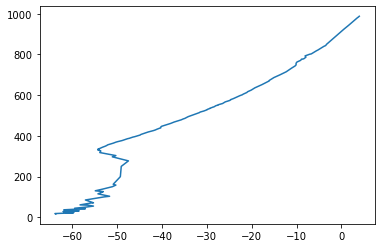

In [31]:
#Using the Dataframe you can make the plot this way
plt.plot(df['Temperature'],df['Pressure'])

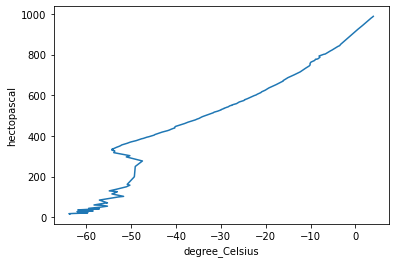

In [32]:
#Using the variables you can make the plot this way
plt.plot(T,p) 

Note the variables have units associated with them and they are used as automatic labels while the dataframe method does not have this. This will be important later. Both ways of handling the data will be useful.

This looks a bit quick and dirty, pressure is goign the wrong way and axes are not the easiest for a human to understand, so let's make it look a bit nicer, using `matplotlib`. 
We then save the figure as a `.jpg` and `.pdf` for future use. Note that the `savefig` function needs to be in the same cell as the code to create the plots in order for the saved files to not be blank! 

Consider which format you want your plots to be saved as and be aware of compression issues with photo formats. Take care not to overwrite a plot by reusing filenames without realising. Due to their use of vector graphics, PDFs work well. However, conventional word processors struggle with importing graphics as PDFs (though it is theoretically possible). If you use $\LaTeX$, PDFs can be used as graphics with minimal fuss.

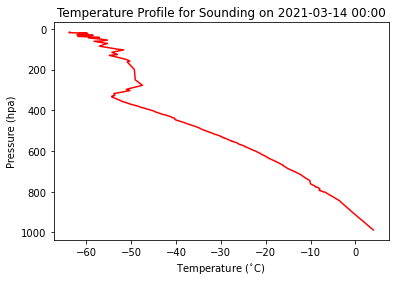

In [33]:
#setup plot axes
fig,ax = plt.subplots()
plt.plot(df['Temperature'],df['Pressure'],'r-') #plot as a green line
plt.xlabel(r'Temperature ($^{\circ}$C) ') 
plt.ylabel('Pressure (hpa)')
ax.invert_yaxis() #pressure descreases with height
plt.title('Temperature Profile for Sounding on '+utc_time.strftime('%Y-%m-%d %H:%M')) #add title, using the date time format codes again

#save this figure as a jpg and pdf
plt.savefig('output/temp.jpg',bbox_inches='tight')
plt.savefig('output/temp.pdf',bbox_inches='tight')

Once the plots are saved, you can select them in the navigation bar and right click (ctrl click on mac) and download the file to your desktop.

Let's go wild and plot the temperature and humidty for this profile at the same time and add a grid to make interpretation easier.

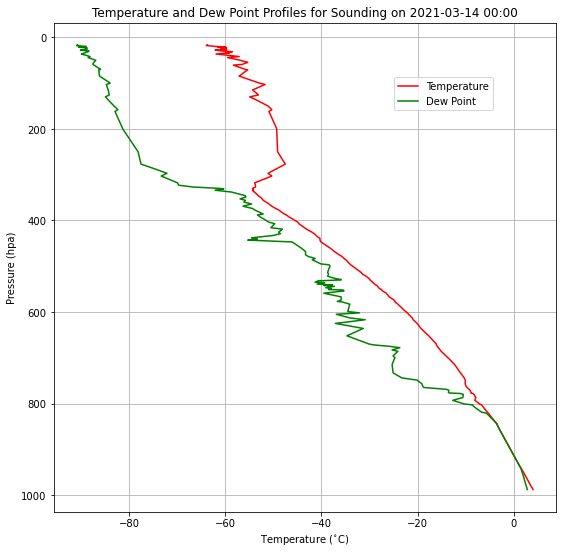

In [34]:
#setup plot axes
fig,ax = plt.subplots(figsize=(9, 9))  #Changes the size of the figure
                      
plt.plot(df['Temperature'],df['Pressure'],'r-',label='Temperature') #plot as a red line

plt.plot(df['Dew_point'],df['Pressure'],'g-',label='Dew Point') #plot as a green line


plt.xlabel(r'Temperature ($^{\circ}$C) ') 
plt.ylabel('Pressure (hpa)')

ax.invert_yaxis() #pressure descreases with height
ax.grid() #add grid

plt.title('Temperature and Dew Point Profiles for Sounding on '+utc_time.strftime('%Y-%m-%d %H:%M')) #add title, using the date time format codes again



#add a legend and save the figures as jpg and pdf
fig.legend(loc=(0.7,0.8),ncol=1)
plt.savefig('output/both.jpg',bbox_inches='tight')
plt.savefig('output/both.pdf',bbox_inches='tight')

## Making Skew T Plots<a name="sec3"></a>

The section above was good for looking at the data but now it would be good to do some more quantitative analysis.
To do this we will make skew T log-P plot using the functions in [MetPy](https://unidata.github.io/MetPy/latest/#).

To start will be continue to use the data from the profile already read in above.

### Basic Skew-T Plotting
The Skew-T (log-P) diagram is a standard way to view radiosonde data. The y-axis is height in pressure coordinates and the x-axis is temperature. The y coordinates are plotted on a logarithmic scale and the x coordinate system is skewed. An explanation of skew-T interpretation is in the Course Handbook. Here we will plot one that can be used for analysis or publication.

Once the data has been read in the most basic skew-T can be plotted with only five lines of Python. These lines perform the following tasks:
1. Create a Figure object and set the size of the figure.
2. Create a SkewT object
3. Plot the pressure and temperature (note that the pressure, the independent variable, is first even though it is plotted on the y-axis).
4. Plot the pressure and dewpoint temperature.
5. Plot the wind barbs at the appropriate pressure using the u and v wind components.


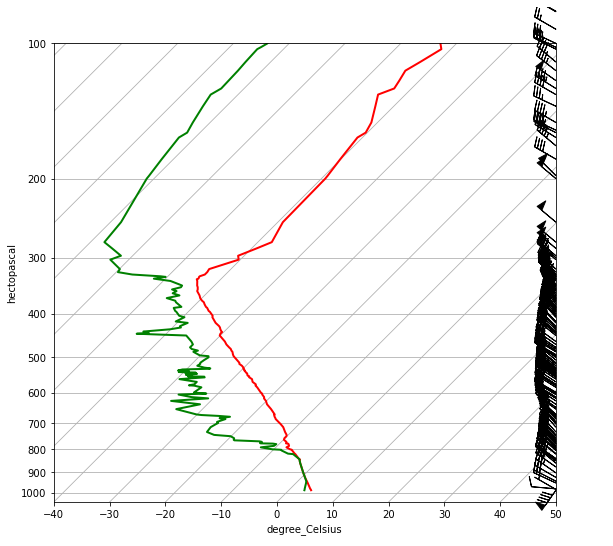

In [35]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig,  rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.show()

OK. So that made a skew-T log-P plot but it is hard to see our profile.  Lets make a few adjustments.

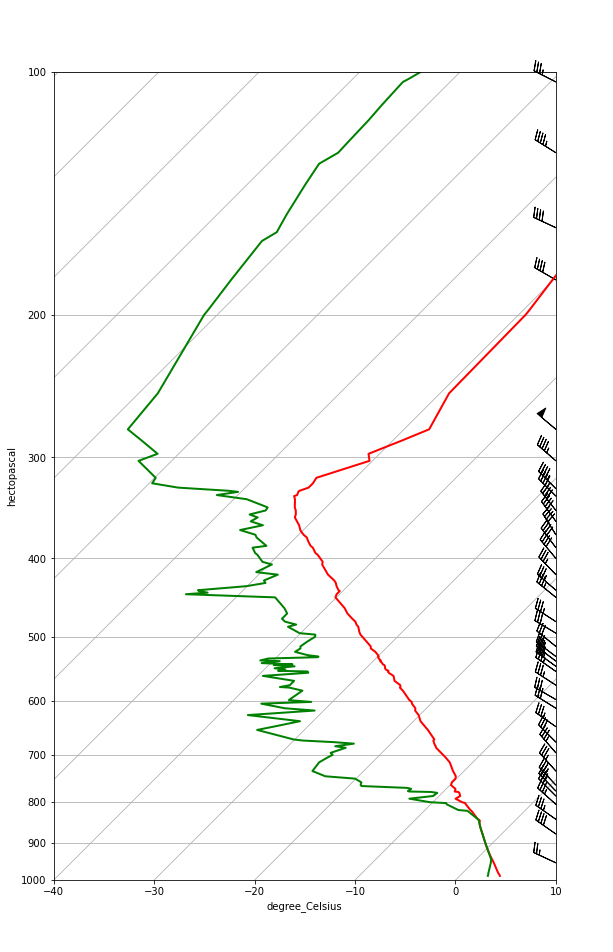

In [36]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 18))
skew = SkewT(fig,rotation=45)
skew.ax.set_ylim(1000, 100) #Changes Pressure limits
skew.ax.set_xlim(-40, 10) #Changes temperature axis limit
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)

p_top=np.where(p<100.* units.hPa)[0][0]
skew.plot_barbs(p[0:p_top:4], u[0:p_top:4], v[0:p_top:4])#Plot every 4th wind barb and cut off at 100hPa

# Show the plot
plt.show()

### Advanced Skew-T Plotting
Fiducial lines indicating dry adiabats, moist adiabats, and mixing ratio are useful when performing further analysis on the Skew-T diagram. Often the 0C isotherm is also emphasized 

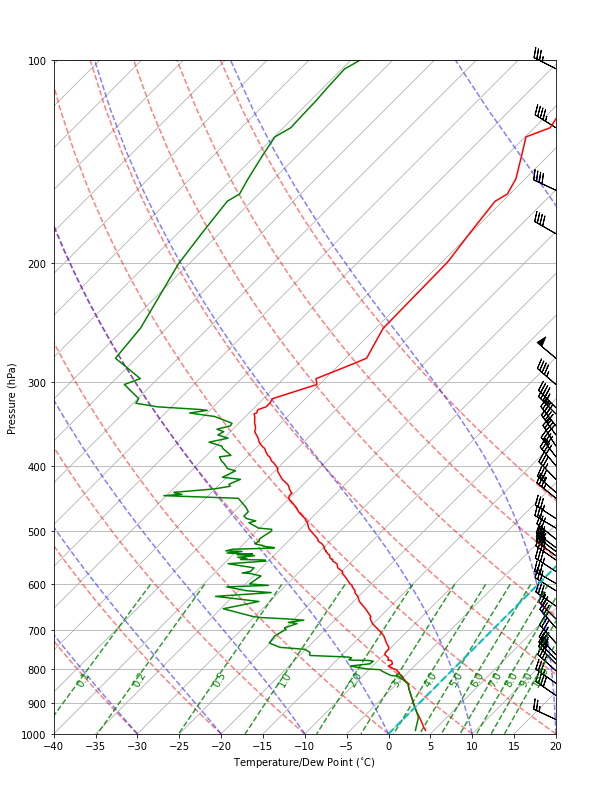

In [37]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 18))

skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
p_top=np.where(p<100.* units.hPa)[0][0]
skew.plot_barbs(p[0:p_top:4], u[0:p_top:4], v[0:p_top:4])#Plot every 4th wind barb and cut off at 100hPa

skew.ax.set_ylim(1000, 100) #Changes Pressure limits

xmin=-40 # Min Temp
xmax= 20 #Max Temp
skew.ax.set_xlim(xmin, xmax) #Changes temperature axis limit
skew.ax.xaxis.set_major_locator(MultipleLocator(5))  #Change X tick interval to 5 degrees C

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
t0 = np.concatenate((np.arange(xmin, 0, 10),np.arange(0, xmax + 41, 10))) * units.degC # Add lines every 5 degrees C
skew.plot_dry_adiabats(t0) #red --
skew.plot_moist_adiabats(t0) #blue ---

mixing_ratio=np.asarray([0.0001, 0.0002,0.0005,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]).reshape(-1, 1)

skew.plot_mixing_lines(mixing_ratio) # green ----

#Add in mixing Ratio Labels
td = mpcalc.dewpoint(mpcalc.vapor_pressure(850* units.mbar, mixing_ratio))
for t,m in zip(td,mixing_ratio):
    plt.annotate("{:<02}".format(np.float(np.round(m*1000,1))),(t.magnitude,850),rotation=60,c='g',fontsize=10)
    
    
plt.xlabel(r'Temperature/Dew Point ($^{\circ}$C)')

plt.ylabel(r'Pressure (hPa)')



# Show the plot
plt.show()



### Adding a Hodogragh

A hodograph is a polar representation of the wind profile measured by the rawinsonde. Winds at different levels are plotted as vectors with their tails at the origin, the angle from the vertical axes representing the direction, and the length representing the speed. The line plotted on the hodograph is a line connecting the tips of these vectors, which are not drawn.

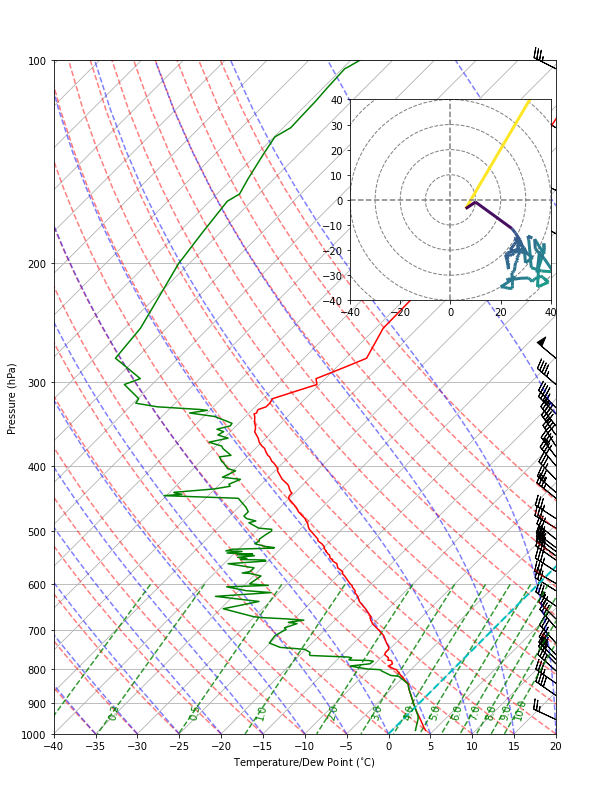

In [38]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 18))

skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
p_top=np.where(p<100.* units.hPa)[0][0]
skew.plot_barbs(p[0:p_top:4], u[0:p_top:4], v[0:p_top:4])#Plot every 4th wind barb and cut off at 100hPa


skew.ax.set_ylim(1000, 100) #Changes Pressure limits

xmin=-40 # Min Temp
xmax= 20 #Max Temp
skew.ax.set_xlim(xmin, xmax) #Changes temperature axis limit
skew.ax.xaxis.set_major_locator(MultipleLocator(5))  #Change X tick interval to 5 degrees C

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
t0 = np.concatenate((np.arange(xmin, 0, 5),np.arange(0, xmax + 41, 5))) * units.degC # Add lines every 5 degrees C
skew.plot_dry_adiabats(t0) #red --
skew.plot_moist_adiabats(t0) #blue ---

mixing_ratio=np.asarray([0.0001, 0.0002,0.0005,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]).reshape(-1, 1) #add a few more lines than default.
skew.plot_mixing_lines(mixing_ratio) # green ----

#Add in mixing Ratio Labels
td = mpcalc.dewpoint(mpcalc.vapor_pressure(950* units.mbar, mixing_ratio))
for t,m in zip(td,mixing_ratio):
    plt.annotate("{:<02}".format(np.float(np.round(m*1000,1))),(t.magnitude,950),rotation=76,c='g',fontsize=10)
    
plt.xlabel(r'Temperature/Dew Point ($^{\circ}$C)')
plt.ylabel(r'Pressure (hPa)')

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '40%', '40%', loc='upper right')
h = Hodograph(ax_hod, component_range=40.)
h.add_grid(increment=10)
h.plot_colormapped(u[0:p_top], v[0:p_top], WS[0:p_top])  # Plot a line colored by wind speed


# Show the plot
plt.show()



## Digging Deeper into the Data<a name="sec4"></a>

Now that we have made a nifty skew-T log-P plot we should see what else we can calculate from the data.


Often times we will want to calculate some thermodynamic parameters of a sounding. These can be estimated by hand using the plots above but he MetPy calc module has many such calculations already implemented!

    Lifting Condensation Level (LCL) - The level at which an air parcel’s relative humidity becomes 100% when lifted along a dry adiabatic path.

    Parcel Path - Path followed by a hypothetical parcel of air, beginning at the surface temperature/pressure and rising dry adiabatically until reaching the LCL, then rising moist adiabatially.


In [39]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[1], T[1], Td[1]) #Skip first row as there is bad data

print('The LCL is at', lcl_pressure, 'and', lcl_temperature)

# Calculate the parcel path profile.
parcel_prof = mpcalc.parcel_profile(p[1:-1], T[1], Td[1]).to('degC')

The LCL is at 969.8977141694268 hectopascal and 2.5395528462026906 degree_Celsius


Lets add these to the skew-T log-P diagram

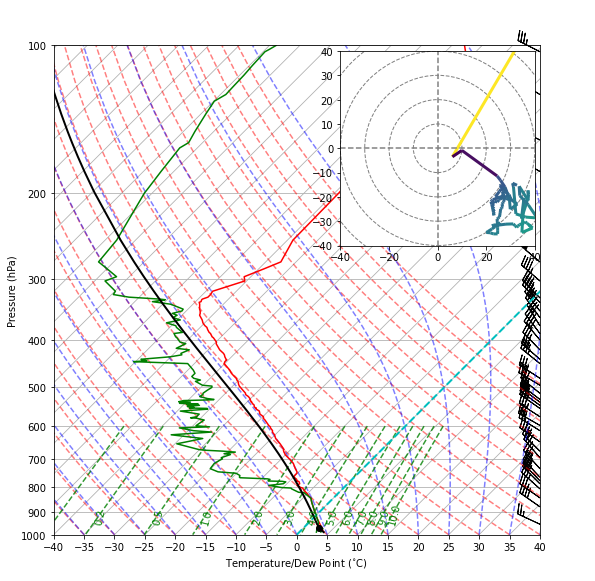

In [40]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(18, 9))

skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
p_top=np.where(p<100.* units.hPa)[0][0]
skew.plot_barbs(p[0:p_top:4], u[0:p_top:4], v[0:p_top:4])#Plot every 4th wind barb and cut off at 100hPa


skew.ax.set_ylim(1000, 100) #Changes Pressure limits

xmin=-40 # Min Temp
xmax= 40 #Max Temp
skew.ax.set_xlim(xmin, xmax) #Changes temperature axis limit
skew.ax.xaxis.set_major_locator(MultipleLocator(5))  #Change X tick interval to 5 degrees C

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
t0 = np.concatenate((np.arange(xmin, 0, 5),np.arange(0, xmax + 41, 5))) * units.degC # Add lines every 5 degrees C
skew.plot_dry_adiabats(t0) #red --
skew.plot_moist_adiabats(t0) #blue ---

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile path as a black line
skew.plot(p[1:-1], parcel_prof, 'k', linewidth=2)
    

mixing_ratio=np.asarray([0.0001, 0.0002,0.0005,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]).reshape(-1, 1) #add a few more lines than default.

skew.plot_mixing_lines(mixing_ratio) # green ----

#Add in mixing Ratio Labels
td = mpcalc.dewpoint(mpcalc.vapor_pressure(950* units.mbar, mixing_ratio))
for t,m in zip(td,mixing_ratio):
    plt.annotate("{:<02}".format(np.float(np.round(m*1000,1))),(t.magnitude,950),rotation=76,c='g',fontsize=10)
    
plt.xlabel(r'Temperature/Dew Point ($^{\circ}$C)')
plt.ylabel(r'Pressure (hPa)')

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '40%', '40%', loc='upper right')
h = Hodograph(ax_hod, component_range=40.)
h.add_grid(increment=10)
h.plot_colormapped(u[0:p_top], v[0:p_top], WS[0:p_top])  # Plot a line colored by wind speed


# Show the plot
plt.show()

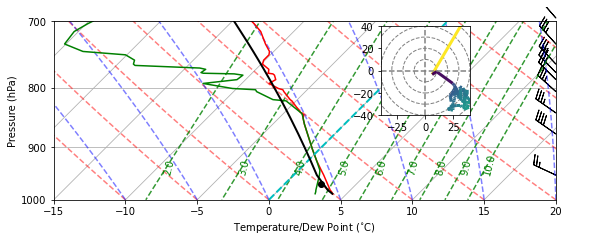

In [42]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))

skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
p_top=np.where(p<100.* units.hPa)[0][0]
skew.plot_barbs(p[0:p_top:4], u[0:p_top:4], v[0:p_top:4])#Plot every 4th wind barb and cut off at 100hPa


skew.ax.set_ylim(1000, 700) #Changes Pressure limits

xmin=-15 # Min Temp
xmax= 20 #Max Temp
skew.ax.set_xlim(xmin, xmax) #Changes temperature axis limit
skew.ax.xaxis.set_major_locator(MultipleLocator(5))  #Change X tick interval to 5 degrees C

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
t0 = np.concatenate((np.arange(xmin, 0, 5),np.arange(0, xmax + 41, 5))) * units.degC # Add lines every 5 degrees C
skew.plot_dry_adiabats(t0) #red --
skew.plot_moist_adiabats(t0) #blue ---

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile path as a black line
skew.plot(p[1:-1], parcel_prof, 'k', linewidth=2)
    

mixing_ratio=np.asarray([0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]).reshape(-1, 1) #add a few more lines than default.
skew.plot_mixing_lines(mixing_ratio) # green ----

#Add in mixing Ratio Labels
td = mpcalc.dewpoint(mpcalc.vapor_pressure(950* units.mbar, mixing_ratio))
for t,m in zip(td,mixing_ratio):
    plt.annotate("{:<02}".format(np.float(np.round(m*1000,1))),(t.magnitude,950),rotation=76,c='g',fontsize=10)
    
plt.xlabel(r'Temperature/Dew Point ($^{\circ}$C)')
plt.ylabel(r'Pressure (hPa)')

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '50%', '50%', loc='upper right')
h = Hodograph(ax_hod, component_range=40.)
h.add_grid(increment=10)
h.plot_colormapped(u[0:p_top], v[0:p_top], WS[0:p_top])  # Plot a line colored by wind speed


# Show the plot
plt.show()



You can see that the location of the LCL and the pacel path do not quote match up with the observations. This is most lilkey due to the initial values of the observed profile being biased in some way or poorly representative of the near surface air. In this case you can start the parcel and LCL calculation with a different value. These differences may tell us something interesting about the boundary layer.

The LCL is at 941.5398667721628 hectopascal and 1.4783839880231382 degree_Celsius


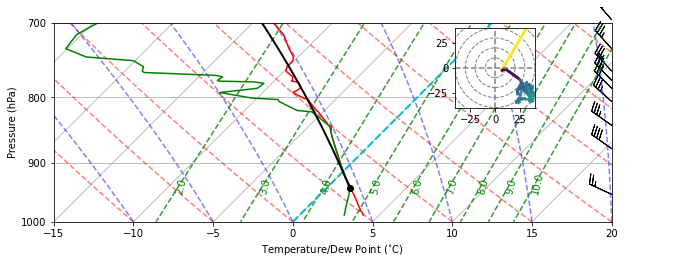

<Figure size 432x288 with 0 Axes>

In [43]:
# Calculate the LCL with a value from higher up.

i=5
lcl_pressure, lcl_temperature = mpcalc.lcl(p[i], T[i], Td[i],100)

print('The LCL is at', lcl_pressure.to(units.hPa), 'and', lcl_temperature)

# Calculate the parcel path profile with a starting value from higher up.
parcel_prof = mpcalc.parcel_profile(p[i:p_top], T[i], Td[i]).to('degC')


# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(10, 10))

skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
p_top=np.where(p<100.* units.hPa)[0][0]
skew.plot_barbs(p[0:p_top:4], u[0:p_top:4], v[0:p_top:4])#Plot every 4th wind barb and cut off at 100hPa


skew.ax.set_ylim(1000, 700) #Changes Pressure limits

xmin=-15 # Min Temp
xmax= 20 #Max Temp
skew.ax.set_xlim(xmin, xmax) #Changes temperature axis limit
skew.ax.xaxis.set_major_locator(MultipleLocator(5))  #Change X tick interval to 5 degrees C

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
t0 = np.concatenate((np.arange(xmin, 0, 5),np.arange(0, xmax + 41, 5))) * units.degC # Add lines every 5 degrees C
skew.plot_dry_adiabats(t0) #red --
skew.plot_moist_adiabats(t0) #blue ---

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile path as a black line
skew.plot(p[i:p_top], parcel_prof, 'k', linewidth=2)
    

mixing_ratio=np.asarray([0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]).reshape(-1, 1) #add a few more lines than default.
skew.plot_mixing_lines(mixing_ratio) # green ----

#Add in mixing Ratio Labels
td = mpcalc.dewpoint(mpcalc.vapor_pressure(950* units.mbar, mixing_ratio))
for t,m in zip(td,mixing_ratio):
    plt.annotate("{:<02}".format(np.float(np.round(m*1000,1))),(t.magnitude,950),rotation=76,c='g',fontsize=10)
    
plt.xlabel(r'Temperature/Dew Point ($^{\circ}$C)')
plt.ylabel(r'Pressure (hPa)')

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '40%', '40%', loc='upper right')
h = Hodograph(ax_hod, component_range=40.)
h.add_grid(increment=10)
h.plot_colormapped(u[0:p_top], v[0:p_top], WS[0:p_top])  # Plot a line colored by wind speed


# Show the plot
plt.show()

#save this figure as a jpg and pdf
plt.savefig('output/skewt_with_lcl_parcelpath.jpg',bbox_inches='tight')
plt.savefig('output/skewt_with_lcl_parcelpath.jpg',bbox_inches='tight')


This function calculates the wet-bulb temperature using the Normand method. 
The LCL is computed, and that parcel brought down to the starting pressure along a moist adiabat.
The Normand method (and others) are described and compared by [Knox2017](https://journals.ametsoc.org/view/journals/bams/98/9/bams-d-16-0246.1.xml).

In [44]:
# Calculate the Wet Bulb Temperature

pressure = [p[1].magnitude] * units.hPa # Silly thing with pressure that makes the calculation work.

wet_bulb_temperature = np.round(mpcalc.wet_bulb_temperature(pressure, T[1], Td[1]),1) 

print('The Wet Bulb Temperature of the Surface is ', wet_bulb_temperature)

The Wet Bulb Temperature of the Surface is  3.4 degree_Celsius


Similarly, you can calculate the wet-bulb temperature at other levels of the atmosphere (heights).

You should make sure this makes sense on the skew-T log-P diagram.

In [45]:
# Calculate the Wet Bulb Temperature

index=10

Level_Height=z[index]

Level_Pressure=p[index]

pressure = [p[index].magnitude] * units.hPa # Silly thing with pressure that makes the calculation work.

wet_bulb_temperature = np.round(mpcalc.wet_bulb_temperature(pressure, T[index], Td[index]),1) 

print('The Wet Bulb Temperature at the ', Level_Height,'(',Level_Pressure,') level is ', wet_bulb_temperature)

The Wet Bulb Temperature at the  1322 meter ( 850.0 hectopascal ) level is  -3.3 degree_Celsius
